# GxE problem

- I updated the simulation function so that sigma is always positive (exponential)
- I am adding the decomposition of the effects
- 100 replicates per scenario

### Next steps

- Find specifications where the test would be misleading

In [38]:
library(brms)
library(rstan)
rstan_options(auto_write = TRUE)
library(data.table)
library(texreg)
library(future)
plan(multiprocess, workers = 3)
source("../src/utils.R")
options(repr.plot.width=4, repr.plot.height=3)

## Definition of error term

In [39]:
createData = function(..., N = 5000, sd = FALSE, print = FALSE) { 

    b0 = 0.8
    b1 = 0.2
    a = 0.5
    h2 = 0.4
    h = sqrt(h2)
    e = sqrt(1-h^2)

    E = rnorm(N,0,1)
    g = rnorm(N,0,1)

    if (print) {
        print(paste0("b0*e = ", round(b0*e, 3), " and b1*e = ", round(b1*e, 3))) 
        print(paste0("G = b0*h = ", round(b0*h, 3), " and GxE = b1*h = ", round(b1*h, 3))) 
        print(paste0("f1 = ", round((b0*h)/(b0*e), 3), " and f2 = ", round((b1*h)/(b1*e),3)))

    }
    sigma = sqrt((b0*e + b1*e*E)^2)
    y = rnorm(N, a*E + b0*h*g + b1*h*E*g, sigma)
    dat = data.frame(y, g, E)
    if (sd) { sd(y) } else { dat }
}

In [40]:
values = replicate(100, createData(sd = TRUE))
data_list = replicate(1, createData(sd = FALSE, print = TRUE), simplify = FALSE)
dat = data.table(data_list[[1]])

[1] "b0*e = 0.62 and b1*e = 0.155"
[1] "G = b0*h = 0.506 and GxE = b1*h = 0.126"
[1] "f1 = 0.816 and f2 = 0.816"


In [131]:
m0 = lm(y ~ -1 + g +E + g:E, data = dat)
dat[, err := (y - predict(m0))^2]
m1 = lm(err ~ 1 + E , data = dat)

In [132]:
summary(dat$err)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.03399  0.15837  0.40493  0.50419 12.59055 

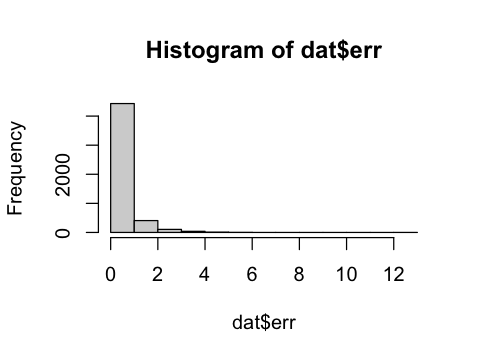

In [133]:
hist(dat$err)

In [134]:
cat(screenreg(list(m0, m1)))



             Model 1      Model 2    
-------------------------------------
g               0.50 ***             
               (0.01)                
E               0.51 ***     0.19 ***
               (0.01)       (0.01)   
g:E             0.11 ***             
               (0.01)                
(Intercept)                  0.41 ***
                            (0.01)   
-------------------------------------
R^2             0.57         0.08    
Adj. R^2        0.57         0.08    
Num. obs.    5000         5000       
*** p < 0.001; ** p < 0.01; * p < 0.05


In [41]:
f0 = bf(y ~ g + E + g * E, sigma ~ 1 + E)
fit0 = brm(f0, data = dat, 
    family = brmsfamily("gaussian", link_sigma = "softplus"))

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL '45fff11fd147af7536503765a97376e0' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.004376 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 43.76 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.74746 seconds (Warm-up)
Chain 1:                4.83871 seconds (Sampling)


In [42]:
summary(fit0)

 Family: gaussian 
  Links: mu = identity; sigma = softplus 
Formula: y ~ g + E + g * E 
         sigma ~ 1 + E
   Data: dat (Number of observations: 5000) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -0.00      0.01    -0.02     0.01 1.00     4484     3309
sigma_Intercept    -0.20      0.01    -0.23    -0.17 1.00     5321     2777
g                   0.51      0.01     0.49     0.53 1.00     4195     2928
E                   0.49      0.01     0.48     0.51 1.00     4604     2931
g:E                 0.12      0.01     0.11     0.14 1.00     4508     3035
sigma_E             0.36      0.01     0.33     0.39 1.00     5588     2651

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on sp

[1] 1.309964

In [143]:
1*0.70

[1] 0.7

In [12]:
f1 = bf(y ~ g + E + g * E) + 
    nlf(sigma ~ (sqrt(vest))^2) + 
    lf(vest ~  1 + E)

f2 = bf(y ~ g + E + g * E) + 
    nlf(sigma ~ sqrt(vest^2)) + 
    lf(vest ~  1 + E)

In [33]:
fit1 = brm(f1, data = data_list, 
    family = brmsfamily("gaussian", link_sigma = "identity"), iter = 6000, warmup = 1000, chains = 2,
    prior = c(prior(student_t(7, 0, 8), class='b', coef = 'E', nlpar = 'vest')), 
    control = list(adapt_delta = 0.99))

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL 'd09864098b57f1c76751f207d6772a81' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: normal_lpdf: Scale parameter[1] is nan, but must be > 0!  (in 'model15ac15816ab75_d09864098b57f1c76751f207d6772a81' at line 42)

Chain 1: 
Chain 1: Gradient evaluation took 0.002286 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 22.86 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 6000 [ 16%]  (Sampling)
Chain 1: Iteration: 1600 / 6000 [ 26%]  (Sampling)
Chain 1: Iteration: 2200 / 6000 [ 36%]  (Sampling)
Chain 1: Iteration: 2800 / 6000 [ 46%]  (Sampling)
Chain 1: Iteration: 3400 / 6000 [ 56%]  (Sampling)
Chain 1: Iteration: 4000 / 6000 [ 66%]  (Sampling)
Chain 1: Iteration: 4600 / 6000 [ 76%]  (Sampling)
Cha

Warning message:
“There were 1 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [34]:
summary(fit1)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ g + E + g * E 
         sigma ~ (sqrt(vest))^2
         vest ~ 1 + E
   Data: data_list (Number of observations: 5000) 
Samples: 2 chains, each with iter = 6000; warmup = 1000; thin = 1;
         total post-warmup samples = 10000

Population-Level Effects: 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          0.01      0.01    -0.01     0.03 1.00     7509     6501
vest_Intercept     0.62      0.01     0.61     0.63 1.00     7327     6390
vest_E             0.16      0.00     0.15     0.16 1.00     7370     7328
g                  0.49      0.01     0.47     0.51 1.00     7278     7058
E                  0.50      0.01     0.49     0.51 1.00     7160     7215
g:E                0.13      0.01     0.12     0.14 1.00     7437     6831

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potenti

In [27]:
# to run texreg
class(fit1) <- c("brmsfit", class(fit1))

In [19]:
suppressWarnings(cat(screenreg(fit1, 
    include.rsquared = TRUE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    reloo = FALSE,
    include.waic = FALSE)))


                Model 1      
-----------------------------
Intercept          0.01      
                [-0.00; 0.03]
vest_Intercept     0.62 *    
                [ 0.61; 0.63]
vest_E             0.16 *    
                [ 0.15; 0.16]
g                  0.49 *    
                [ 0.48; 0.51]
E                  0.50 *    
                [ 0.49; 0.51]
g:E                0.13 *    
                [ 0.12; 0.14]
-----------------------------
R^2                0.55      
Num. obs.       5000         
* 0 outside the confidence interval.


In [35]:
hyp <- "g * vest_E = g:E * vest_Intercept"
(hyp <- hypothesis(fit1, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*vest_E)-(g:E*v... = 0        0         0    -0.01        0         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

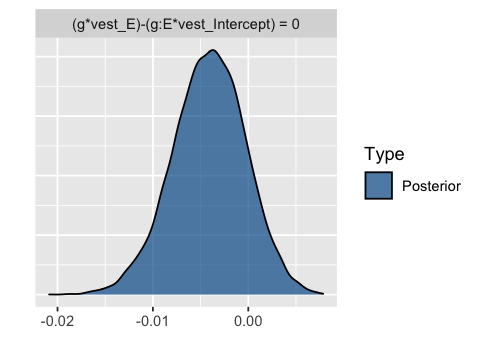

In [36]:
plot(hyp)

2.5%  97.5% 
-0.043  0.137

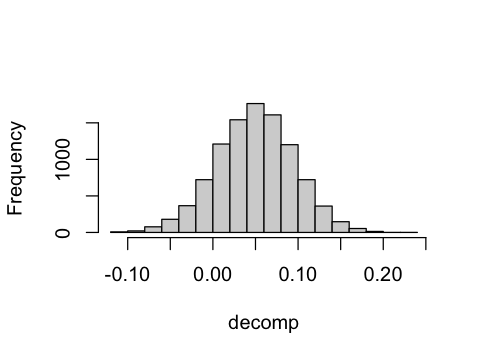

In [37]:
v = decompR(fit1, p0 = "g", p1 = "g:E", l0 = "vest_intercept", l1 = "vest_e")
round(quantile(v, probs = c(0.025, 0.975)), 3)
hist(v, main = "", xlab = "decomp")

## Functions

In [55]:
# scaling model 
simScaling = function(E, a0 = 0, a1 = 0.5, b0 = 0.8, b1 = 0.2, h2 = 0.5) {
    N = length(E)
    G = rnorm(N,0,1)
    h = sqrt(h2)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    y = rnorm(N, a0 + a1*E + b0*h*G + b1*h*E*G, sigma)
    df = data.frame(E = E, y = y, g = G)
}

# interaction model
simInteraction = function(E, a0 = 0.0, a1 = 0.5, b0 = 0.8, b1 = 0.20, sb0 = 0.1, sb1 = 0.15) {
    N = length(E)
    G = rnorm(N,0,1)
    sigma = exp(sb0 + sb1 * E) 
    y = rnorm(N, a0 + a1*G + b0*E + b1*G*E, sigma)
    df = data.frame(E = E, y = y, g = G)
}

# interaction + scaling model
simScalingInteraction = function(E, a0 = 0.0,  a1 = 0.5, a2 = 0.10, b0 = 0.8, b1 = 0.2, h2 = 0.5) {
    N = length(E)
    G = rnorm(N,0,1)
    h = sqrt(h2)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    y = rnorm(N, a0 + a1*E + a2*G*E + b0*h*G + b1*h*E*G, sigma)
    df = data.frame(E = E, y = y, g = G)
}

# domingue's original function
simDom = function(E,b0 = .8, b1 = .2, b2 = 0, b3 = .05, h = sqrt(.6), a =.5, sigma = 1, scaling = TRUE) {
    N = length(E)
    G = rnorm(N,0,1)
    eps = rnorm(N,0,sigma)
    if (scaling){
        e = sqrt(1-h^2)
        ystar = h*G+e*eps
        y = a*E+(b0 + b1*E)*ystar
    } else {
        y = b1*G+b2*E+b3*G*E+eps
    }
    df = data.frame(E=E,y=y,g=G)
}

## Simulating data

In [56]:
E = rnorm(5000, 0, 1)
replicates = 30
dts = replicate(replicates, simScaling(E), simplify = FALSE)
dti = replicate(replicates, simInteraction(E), simplify = FALSE)
dtsi = replicate(replicates, simScalingInteraction(E), simplify = FALSE)
dom = replicate(replicates, simDom(E, scaling = TRUE), simplify = FALSE)

In [57]:
cnames = c("Scaling", "Interaction", "Scaling + Interaction", "Domingue's simulation")
models = list()
models[[1]] = lm(y ~ g + E + g * E, data = dts[[1]])
models[[2]] = lm(y ~ g + E + g * E, data = dti[[1]])
models[[3]] = lm(y ~ g + E + g * E, data = dtsi[[1]])
models[[4]] = lm(y ~ g + E + g * E, data = dom[[1]])
cat(screenreg(models, custom.model.names = cnames))


             Scaling      Interaction  Scaling + Interaction  Domingue's simulation
-----------------------------------------------------------------------------------
(Intercept)    -0.03         0.03        -0.01                  -0.00              
               (0.02)       (0.02)       (0.03)                 (0.01)             
g               0.59 ***     0.50 ***     0.56 ***               0.63 ***          
               (0.02)       (0.02)       (0.03)                 (0.01)             
E               0.49 ***     0.83 ***     0.50 ***               0.50 ***          
               (0.02)       (0.02)       (0.03)                 (0.01)             
g:E             0.14 ***     0.23 ***     0.28 ***               0.16 ***          
               (0.02)       (0.02)       (0.03)                 (0.01)             
-----------------------------------------------------------------------------------
R^2             0.17         0.44         0.17                   0.70      


# Bayesian distributional model


In [58]:
# distributional model using bayesian stats
f = bf(y ~ g + E + g * E, sigma ~ 1 + E)
b1 = brm_multiple(f, data = dts, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b2 = brm_multiple(f, data = dti, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b3 = brm_multiple(f, data = dtsi, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b4 = brm_multiple(f, data = dom, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)

Compiling the C++ model



In [ ]:
# checking convergence of models
rb1 = unlist(b1$rhats)
rb2 = unlist(b2$rhats)
rb3 = unlist(b3$rhats)
rb4 = unlist(b4$rhats)
print(table(rb1 > 1.05 | rb1 < 0.95))
print(table(rb2 > 1.05 | rb2 < 0.95))
print(table(rb3 > 1.05 | rb3 < 0.95))
print(table(rb4 > 1.05 | rb4 < 0.95))

In [ ]:
# able to recover the correct sigma coefficients 
suppressWarnings(cat(screenreg(list(b1, b2, b3, b4), custom.model.names = cnames, 
    use.HDI = TRUE,
    include.rsquared = TRUE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    include.waic = FALSE)))

# Tests

## Scaling

In [ ]:
# I cannot reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b1, hyp, alpha = 0.05))

In [ ]:
plot(hyp)

In [ ]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b1))

## Interaction

In [ ]:
# I reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b2, hyp, alpha = 0.05))

In [ ]:
plot(hyp)

In [ ]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b2))

## Interaction + Scaling

In [ ]:
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

In [ ]:
plot(hyp)

In [ ]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b3))

# Domingue's simulation

In [ ]:
# wrong test
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b4, hyp, alpha = 0.05))

# A more complex heritability function

$$ V_P = V_G + V_E + Cov(V_G, V_E) + V_{HD}$$

- G = Genetic info
- E = Enviroment
- HD = Developmental noise

In [ ]:
# simulation variables
simComplexH = function(E, a = 0.0, a1 = 0.5, b0 = 0.3, b1 = 0.2, 
    hg = 0.3, he = 0.3, hge = 0.2, print = FALSE) {
    
    n = length(E)
    G = rnorm(n)

    hd = 1 - (hg + he + hge)
    if (print) print(paste0("Total sum of coefficients: ", sum(hg, he, hge, hd)))   

    hg = sqrt(hg)
    he = sqrt(he)
    hge = sqrt(hge)
    hd = sqrt(hd)
    
    ys = hg * G + he * E + hge * G * E

    if (print) {
    
    print(paste0("Sigma intercept: ", b0*hd))
    print(paste0("Sigma slope: ", b1 * hd))
    }
    
    sigma = exp(b0 * hd  + b1 * hd * E)
    eps = rnorm(n, 0, sigma)
    y = a + a1 * E + (b0 + b1 * E) * ys + eps
    #y = a + (b0 + b1 * E) * ys + eps
    dat = data.table(y, G, E)
}

In [ ]:
E = rnorm(5000)
dd = replicate(10, simComplexH(E), simplify = FALSE)

In [ ]:
cat(screenreg(list( 
    lm(y ~ G + E + E*G, data = dd[[1]]))))

In [ ]:
f = bf(y ~ G + E + E * G, sigma ~ E)
test = brm_multiple(f, data = dd)

In [ ]:
suppressWarnings(cat(screenreg(test, 
    include.rsquared = FALSE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    reloo = FALSE,
    include.waic = FALSE)))

In [ ]:
hyp <- "G * sigma_E = G:E * sigma_Intercept"
(hyp <- hypothesis(test, hyp, alpha = 0.05))

In [ ]:
plot(hyp)

In [ ]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(test))

In [90]:
# model with 'treat' as predictor
fit1 <- brm(rating ~ treat + period + carry, data = inhaler)
summary(fit1)

# model without 'treat' as predictor
fit2 <- brm(rating ~ period + carry, data = inhaler)
summary(fit2)

# compute model-averaged predicted values
(df <- unique(inhaler[, c("treat", "period", "carry")]))
pp_average(fit1, fit2, newdata = df)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'c3641cc15f22bbf603fe8c6c59a576b6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.039158 seconds (Warm-up)
Chain 1:                0.03784 seconds (Sampling)
C

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: rating ~ treat + period + carry 
   Data: inhaler (Number of observations: 572) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.43      0.03     1.38     1.48 1.00     4486     2520
treat        -0.25      0.07    -0.39    -0.11 1.00     3658     2992
period        0.05      0.05    -0.05     0.16 1.00     5116     2878
carry        -0.04      0.05    -0.15     0.05 1.00     3697     3122

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.61      0.02     0.57     0.65 1.00     4943     2882

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL 'c3641cc15f22bbf603fe8c6c59a576b6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.024079 seconds (Warm-up)
Chain 1:                0.028177 seconds (Sampling)


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: rating ~ period + carry 
   Data: inhaler (Number of observations: 572) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.43      0.03     1.38     1.48 1.00     4373     2989
period        0.05      0.05    -0.05     0.16 1.00     4368     2918
carry        -0.17      0.04    -0.24    -0.10 1.00     4347     2646

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.61      0.02     0.58     0.65 1.00     4109     3133

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

,treat,period,carry
,<dbl>,<dbl>,<dbl>
1,0.5,0.5,0
60,-0.5,0.5,0
287,-0.5,-0.5,-1
346,0.5,-0.5,1


Estimate,Est.Error,Q2.5,Q97.5
1.345670,0.6165974,0.129117108,2.559994
1.588605,0.6143022,0.400964768,2.795589
1.571377,0.6140600,0.367283615,2.777377
1.231711,0.6249903,-0.008284768,2.442849


In [92]:
models = list(fit1, fit2)

In [94]:
pp_average(models[[1]], models[[2]], newdata = df)

Estimate,Est.Error,Q2.5,Q97.5
1.346401,0.6047186,0.14856693,2.519132
1.568425,0.6184052,0.36486419,2.806147
1.596783,0.6137072,0.40129037,2.795057
1.233666,0.6208822,0.03564727,2.465377


In [120]:
invoke(pp_average, models, newdata = df, weights = c(0.3, 0.70),summary = TRUE)

Estimate,Est.Error,Q2.5,Q97.5
1.433093,0.6158400,0.2332975,2.626969
1.499231,0.6253996,0.2474564,2.733737
1.574194,0.6107296,0.3988573,2.773741
1.234223,0.6097361,0.0328062,2.417956


In [135]:
test = list("2002" = c(1, 2,3, 4), "2004" = c(6, 7, 8, 9))

In [136]:
a = setDT(test)

In [138]:
a

2002,2004
<dbl>,<dbl>
1,6
2,7
3,8
4,9
